In [1]:
import os
import sys
import math
from collections import Counter
import pickle

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.datasets import make_blobs
import torch
from torch import nn, optim

sys.path.append("/Users/eric/Code/healthcare-breast-recommender/")

from src.utils import compute_distance
from src.config import CENTERS_COLORS
from src import viz

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Toy dataset

## Draw care centers & patients

In [4]:
# Setup problem
n_patients = 1000
n_centers = 3
radius = 500

# Care centers location & capacity
infinite_capacity = False

if infinite_capacity:
    care_centers_capacity = np.asarray([n_patients]*n_centers)
    care_centers_capacity = care_centers_capacity.reshape(1, -1)
else:
    care_centers_capacity = np.round(
        np.multiply(
            n_patients,
            np.random.dirichlet(np.ones(n_centers), size=1)
        )
    ).astype(int)
    care_centers_capacity = care_centers_capacity + 10  # add extra spots

centers_x = []
centers_y = []
for i in np.random.rand(n_centers):
    alpha = 2 * math.pi * i
    x_i = np.cos(alpha) * radius
    y_i = np.sin(alpha) * radius
    
    centers_x.append(x_i)
    centers_y.append(y_i)

# Patients location
patients_x = []
patients_y = []
for i in np.random.rand(n_patients):
    alpha = 2 * math.pi * i
    x_i = np.cos(alpha) * radius
    y_i = np.sin(alpha) * radius
    
    patients_x.append(x_i)
    patients_y.append(y_i)

# Compute travel distances

In [5]:
D = np.zeros(
    shape=(n_patients, n_centers)
)

for i in range(n_patients):
    for j in range(n_centers):
        _, d_ij = compute_distance(
            patients_x[i],
            patients_y[i],
            centers_x[j],
            centers_y[j],
            radius=radius
        )
        
        D[i][j] = d_ij

## Assign patients to care centers

### Generate patients & care centers embeddings

In [6]:
# draw points, from multiple "clusters"
X, group = make_blobs(
    n_samples=n_patients+n_centers,
    n_features=2,
    centers=n_centers,
    random_state=10
)

# pick points from each group and convert it to a center
care_centers_rows = list(np.random.choice(np.where(group==0)[0], 1, replace=False)) \
                  + list(np.random.choice(np.where(group==1)[0], 1, replace=False)) \
                  + list(np.random.choice(np.where(group==2)[0], 1, replace=False))

X_centers = X[care_centers_rows, :]
X_patients = np.delete(X, care_centers_rows, axis=0)

X_patients_norm = X_patients / np.linalg.norm(X_patients, axis=1).reshape(-1, 1)
X_centers_norm = X_centers / np.linalg.norm(X_centers, axis=1).reshape(-1, 1)

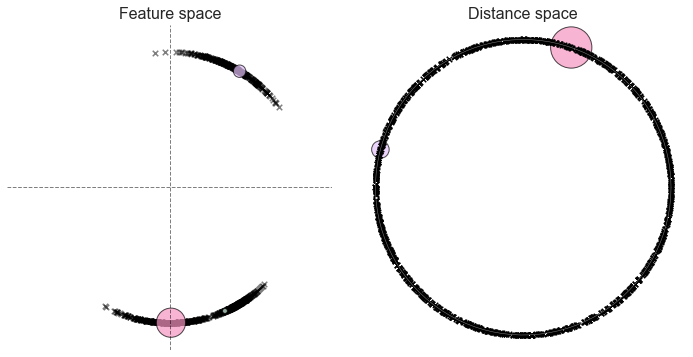

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

viz.plot_embeddings(
    torch.from_numpy(X_patients_norm), 
    torch.from_numpy(X_centers_norm), 
    care_centers_capacity, 
    None, 
    axs[0]
)

viz.plot_distances(
    np.asarray(list(zip(patients_x, patients_y))),
    np.asarray(list(zip(centers_x, centers_y))),
    radius, 
    None, 
    care_centers_capacity, 
    axs[1]
)

axs[0].set_title("Feature space", fontsize=16)
axs[1].set_title("Distance space", fontsize=16)

plt.tight_layout()
plt.show()

### Linear Assignment Problem

- https://en.wikipedia.org/wiki/Assignment_problem
- https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html

In [10]:
distance_weight = 0.5
C = (1 - distance_weight) * np.dot(X_patients_norm, X_centers_norm.T) - distance_weight * (D/np.mean(D))

C_with_capacity = np.hstack(
    [np.repeat(C[:, i].reshape(-1, 1), c, axis=1) 
     for i, c in enumerate(care_centers_capacity[0])]
)

column_to_center_ix = np.hstack(
    [np.repeat([i], c) 
     for i, c in enumerate(care_centers_capacity[0])]
)

row_ix, col_ix = optimize.linear_sum_assignment(C_with_capacity, maximize=True)

print("Total cost = {0:.1f}".format(C_with_capacity[row_ix, col_ix].sum()))

Total cost = -57.2


In [11]:
assigned_center_for_patient = np.asarray([column_to_center_ix[i] for i in col_ix])

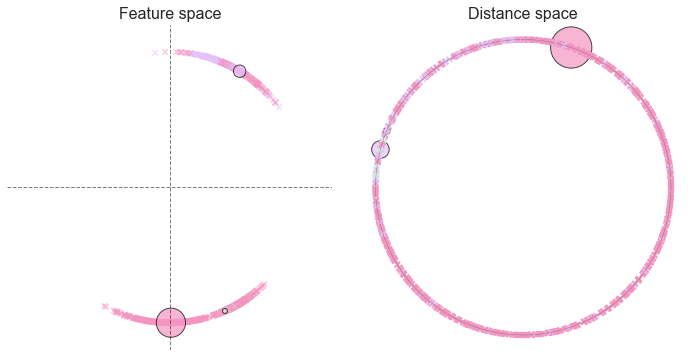

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

viz.plot_embeddings(
    torch.from_numpy(X_patients_norm), 
    torch.from_numpy(X_centers_norm),
    care_centers_capacity, 
    assigned_center_for_patient, 
    axs[0]
)

viz.plot_distances(
    np.asarray(list(zip(patients_x, patients_y))),
    np.asarray(list(zip(centers_x, centers_y))),
    radius, 
    assigned_center_for_patient, 
    care_centers_capacity, 
    axs[1]
)

axs[0].set_title("Feature space", fontsize=16)
axs[1].set_title("Distance space", fontsize=16)

plt.tight_layout()
plt.show()